# M2D-CLAP example

This is an example of the CLAP features from M2D-CLAP $_{2025}$, the journal paper version.

Download and prepare the wweight [`m2d_clap_vit_base-80x1001p16x16p16kpBpTI-2025`](https://github.com/nttcslab/m2d/releases/download/v0.5.0/m2d_clap_vit_base-80x1001p16x16p16kpBpTI-2025.zip) before you run.

```bibtex
@article{niizumi2025m2d-clap,
    title   = {{M2D-CLAP: Exploring General-purpose Audio-Language Representations Beyond CLAP}},
    author  = {Daisuke Niizumi and Daiki Takeuchi and Masahiro Yasuda and Binh Thien Nguyen and Yasunori Ohishi and Noboru Harada},
    journal = {IEEE Access},
    year    = {2025},
    url     = {https://ieeexplore.ieee.org/document/11168481}}
```

In [1]:
import warnings; warnings.simplefilter('ignore')
import logging
logging.basicConfig(level=logging.INFO)
import torch
from pathlib import Path
import numpy as np

In [2]:
from portable_m2d import PortableM2D
weight = 'm2d_clap_vit_base-80x1001p16x16p16kpBpTI-2025/checkpoint-30.pth'
model = PortableM2D(weight_file=weight, flat_features=True)


INFO:root:<All keys matched successfully>
INFO:root:Model input size: [80, 1001]
INFO:root:Using weights: m2d_clap_vit_base-80x1001p16x16p16kpBpTI-2025/checkpoint-30.pth
INFO:root:Feature dimension: 768
INFO:root:Norm stats: -7.261779308319092, 4.3511505126953125
INFO:root:Runtime MelSpectrogram(16000, 400, 400, 160, 80, 50, 8000):
INFO:root:MelSpectrogram(
  Mel filter banks size = (80, 201), trainable_mel=False
  (stft): STFT(n_fft=400, Fourier Kernel size=(201, 1, 400), iSTFT=False, trainable=False)
)


 using 166 parameters from m2d_clap_vit_base-80x1001p16x16p16kpBpTI-2025/checkpoint-30.pth
 (included audio_proj params: ['audio_proj.sem_token', 'audio_proj.sem_blocks.0.norm1.weight', 'audio_proj.sem_blocks.0.norm1.bias', 'audio_proj.sem_blocks.0.attn.qkv.weight', 'audio_proj.sem_blocks.0.attn.qkv.bias']
 (included text_proj params: []
 (dropped: [] )
<All keys matched successfully>
 using norm_stats: -7.261779308319092, 4.3511505126953125


In [3]:
files = ['AudioSetWav16k/eval_segments/-22tna7KHzI_28.000.wav',
    'AudioSetWav16k/eval_segments/-0xzrMun0Rs_30.000.wav',
    'AudioSetWav16k/eval_segments/3tUlhM80ObM_0.000.wav',
    'AudioSetWav16k/eval_segments/-1nilez17Dg_30.000.wav',
    'AudioSetWav16k/eval_segments/--U7joUcTCo_0.000.wav',
    'AudioSetWav16k/eval_segments/5hlsVoxJPNI_30.000.wav',]
captions = ['The sound of Explosion.',
    'The sound of Stomach rumble, and Music.',
    'The sound of Knock.',
    'The sound of Heart murmur, and Speech.',
    "A man's laughter abruptly interrupts as someone sneezes, suggesting a casual gathering or social event.",
    "The sound of Christmas music, Music, and Speech.",]

In [4]:
import librosa

with torch.no_grad():
    audios = [librosa.load(f, sr=16000)[0] for f in files]
    audios = [np.pad(a, (0, 16000 * 10 - a.shape[-1])) for a in audios]  # Make sure all files are 10-s.
    audios = torch.tensor(audios)
    audio_embs = model.encode_clap_audio(audios)
    text_embs = model.encode_clap_text(captions)

INFO:root: using text encoder: BERT base


 using model.text_encoder from m2d_clap_vit_base-80x1001p16x16p16kpBpTI-2025/checkpoint-30.pth


In [5]:
audio_embs.shape, text_embs.shape

(torch.Size([6, 768]), torch.Size([6, 768]))

[[0.28606 0.2381  0.23852 0.21239 0.11076 0.13236]
 [0.22148 0.37747 0.2139  0.18893 0.12501 0.21492]
 [0.26712 0.24247 0.37288 0.21389 0.10618 0.15825]
 [0.18678 0.22834 0.20472 0.39384 0.10315 0.22582]
 [0.25185 0.13545 0.23883 0.18921 0.32387 0.1312 ]
 [0.19546 0.24592 0.1791  0.23728 0.0799  0.31999]]


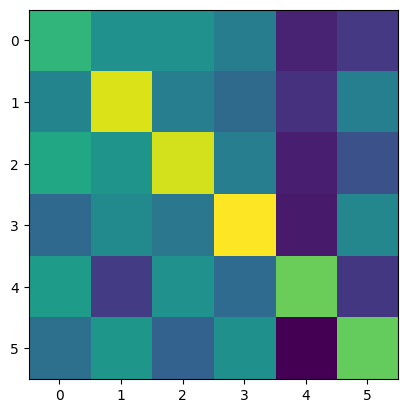

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

H = cosine_similarity(audio_embs, text_embs)
plt.imshow(H, interpolation='none')
np.set_printoptions(precision=5, suppress=True)
print(H)